# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **FPL player score** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, combine predictions with static data
3. Store predictions in a monitoring feature group

## <span style='color:#ff5f27'> 📝 Imports

In [260]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
from importlib import reload

In [261]:
reload(util)

print(util.get_gameweek_from_date("2025-1-4"))

20


In [262]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)

# Get the gameweek from the date
gameweek = util.get_gameweek_from_date(str(today.date()))
last_gameweek = gameweek - 1

gameweek
last_gameweek

19

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [263]:
try:
    with open('./hopsworks/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
except:
    print("In production mode")

project = hopsworks.login()
fs = project.get_feature_store()

2025-01-05 17:15:14,438 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-05 17:15:14,444 INFO: Initializing external client
2025-01-05 17:15:14,445 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-05 17:15:15,975 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159321


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [264]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="player_score_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [265]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.1982019E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'floa...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Player Score Features From Previous Gameweek </span>



In [266]:
players_fg = fs.get_feature_group(
    name='player_features',
    version=1,
)
input_data = players_fg.filter(players_fg.gameweek == last_gameweek).read()
output_data = players_fg.filter(players_fg.gameweek == gameweek).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [267]:
inputs = ['prev_minutes', 'prev_goals_scored', 'prev_assists',
         'prev_clean_sheets', 'prev_goals_conceded', 'prev_own_goals',
         'prev_penalties_saved', 'prev_penalties_missed', 'prev_yellow_cards',
         'prev_red_cards', 'prev_saves', 'prev_bonus',
         'prev_bps', 'prev_influence', 'prev_creativity',
         'prev_threat', 'prev_ict_index', 'prev_starts',
         'prev_expected_goals', 'prev_expected_assists', 'prev_expected_goal_involvements',
         'prev_expected_goals_conceded', 'prev_in_dreamteam']

for i in range(0, len(input_data)):
    output_data.at[i, 'predicted_score'] = retrieved_xgboost_model.predict(input_data.loc[i, inputs].values.reshape(1, -1))[0]

output_data

,id,total_points,gameweek,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,...,prev_creativity,prev_threat,prev_ict_index,prev_starts,prev_expected_goals,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam,predicted_score
0,253,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.503806
1,254,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2.536139
2,489,2,20,90.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.3,0.0,1.7,1.0,0.00,0.01,0.01,0.72,0.0,1.754258
3,252,9,20,67.0,1.0,0.0,0.0,1.0,0.0,0.0,...,4.0,48.0,9.6,1.0,0.36,0.00,0.36,1.52,0.0,0.214927
4,255,4,20,90.0,0.0,1.0,0.0,2.0,0.0,0.0,...,40.8,4.0,8.3,1.0,0.00,0.22,0.22,1.98,0.0,2.843832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,585,2,20,90.0,0.0,0.0,0.0,1.0,0.0,0.0,...,44.1,34.0,9.3,1.0,0.35,0.60,0.95,0.94,0.0,0.214927
705,543,1,20,90.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.8,17.0,3.2,1.0,0.14,0.01,0.15,2.25,0.0,NaN
706,564,1,20,90.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.7,1.0,1.6,1.0,0.02,0.00,0.02,2.25,0.0,NaN
707,192,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN


In [268]:
output_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               709 non-null    int64  
 1   total_points                     709 non-null    int64  
 2   gameweek                         709 non-null    int64  
 3   prev_minutes                     709 non-null    float64
 4   prev_goals_scored                709 non-null    float64
 5   prev_assists                     709 non-null    float64
 6   prev_clean_sheets                709 non-null    float64
 7   prev_goals_conceded              709 non-null    float64
 8   prev_own_goals                   709 non-null    float64
 9   prev_penalties_saved             709 non-null    float64
 10  prev_penalties_missed            709 non-null    float64
 11  prev_yellow_cards                709 non-null    float64
 12  prev_red_cards        

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

### Create Score Graph
Draw a graph of the predictions with all the players as a PNG and save it to the github

2025-01-05 17:15:24,904 WARNING: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.



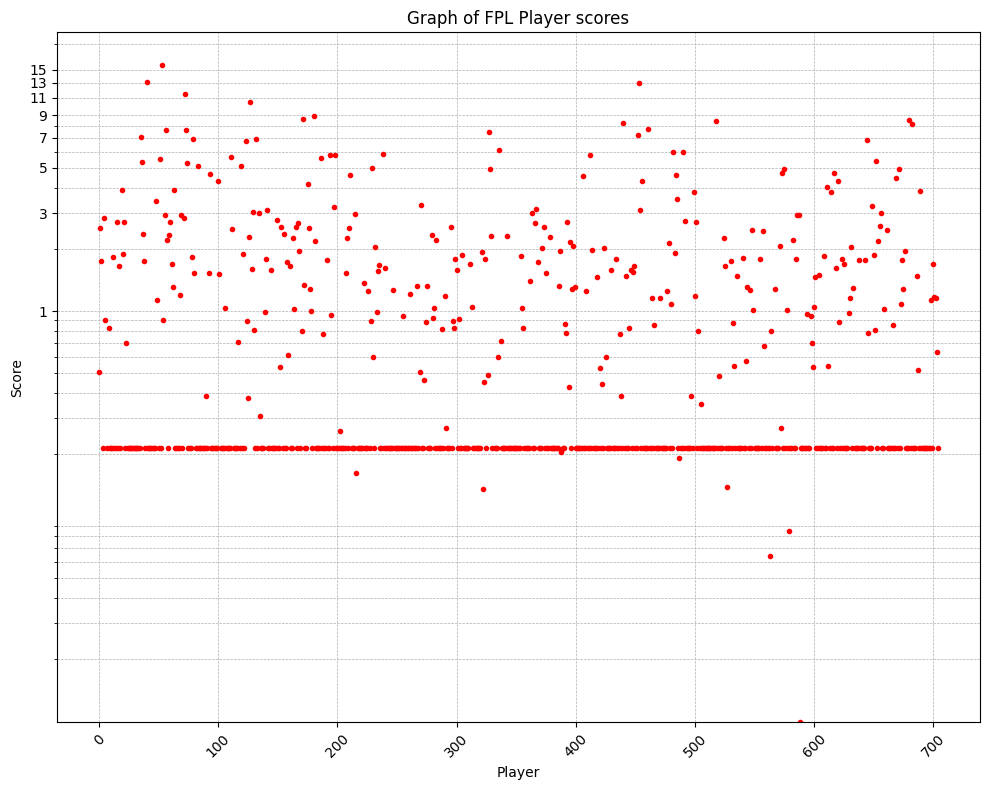

In [269]:
file_path = "./player_score_model/images/predicted_scores.png"
plt = util.plot_player_score_forecast("FPL Player scores", output_data, file_path)
plt.show()

In [270]:
# Get or create feature group
monitor_fg = fs.get_feature_group(
    name='fpl_predictions',
    # description='FPL player score prediction monitoring',
    version=1,
    # primary_key=['id', 'gameweek']
)

In [271]:
# monitor_fg.read().head()

In [272]:
# Only keep the relevant columns
output_data = output_data[['id', 'total_points', 'gameweek', 'predicted_score']]

output_data

,id,total_points,gameweek,predicted_score
0,253,0,20,0.503806
1,254,0,20,2.536139
2,489,2,20,1.754258
3,252,9,20,0.214927
4,255,4,20,2.843832
...,...,...,...,...
704,585,2,20,0.214927
705,543,1,20,NaN
706,564,1,20,NaN
707,192,0,20,NaN


In [273]:
# Add static data
for i in range(0, len(output_data)):
    player_id = output_data.loc[i, 'id']

    player_data = util.get_player_info(player_id)
    for key in player_data:
        output_data.at[i, key] = player_data[key]

2025-01-05 17:15:25,353 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-01-05 17:15:25,355 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-01-05 17:15:25,356 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [274]:
output_data.head()

# Add empty column
output_data['previous_predicted_score'] = 0

2025-01-05 17:15:49,819 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [275]:
# Get previous predictions if present
previous_predictions = []

# Check if minotoring feature group is empty by checking if it can be read without errors
try:
    monitor_fg.read()
except:
    skip = True

if skip == False:
    latest_gameweeks = monitor_fg.filter(monitor_fg.gameweek >= (int(gameweek) - 5) and monitor_fg.gameweek <= int(gameweek)).read()

    latest_gameweeks

    for i in range(0, len(output_data)):
        player_id = output_data.loc[i, 'id']

        # Check if the player has been predicted before
        player_predictions = latest_gameweeks[latest_gameweeks.id == player_id]


        if len(player_predictions) > 0:
            # Sort the predictions by gameweek
            player_predictions = player_predictions.sort_values(by='gameweek', ascending=False)

            # only keep the relevant columns
            player_predictions = player_predictions[['total_points', 'gameweek', 'predicted_score']]

            # print(player_predictions.info())

            # Update the output data with the previous prediction
            output_data.at[i, 'previous_predicted_score'] = player_predictions.to_dict('records')
        else:
            pass

    output_data
    # output_data_copy = pd.DataFrame(output_data_copy)

    # output_data_copy = output_data_copy.dropna(subset=['previous_predicted_score'])
    # print(output_data_copy)
else:
    print("No previous data found in feature group")

No previous data found in feature group


In [276]:
print(output_data)

      id  total_points  gameweek  predicted_score      name         team  \
0    253             0        20         0.503806      Ream         None   
1    254             0        20         2.536139      Reed         None   
2    489             2        20         1.754258      Gray         None   
3    252             9        20         0.214927      Raúl         None   
4    255             4        20         2.843832  Robinson         None   
..   ...           ...       ...              ...       ...          ...   
704  585             2        20         0.214927    I.Sarr  Aston Villa   
705  543             1        20              NaN   Doherty  Southampton   
706  564             1        20              NaN   S.Bueno  Southampton   
707  192             0        20              NaN    J.Ayew      Everton   
708  405             0        20              NaN    Krafth         None   

       position  previous_predicted_score  
0      Defender                         0  

In [277]:
monitor_fg.insert(output_data, overwrite=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1159321/fs/1150024/fg/1393569


Uploading Dataframe: 100.00% |██████████| Rows 709/709 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: fpl_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1159321/jobs/named/fpl_predictions_1_offline_fg_materialization/executions


(Job('fpl_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [279]:
monitor_fg.update_feature_description("id", "Player ID")
monitor_fg.update_feature_description("total_points", "Total points of the player in the gameweek (label)")
monitor_fg.update_feature_description("gameweek", "Gameweek")
monitor_fg.update_feature_description("predicted_score", "Predicted score of the player in the gameweek")
monitor_fg.update_feature_description("name", "Player name")
monitor_fg.update_feature_description("team", "Player team")
monitor_fg.update_feature_description("position", "Player position")
monitor_fg.update_feature_description("previous_predicted_score", "Previous (max 5) predicted scores of the player")


---